In [ ]:
%%bash
git config --global user.name "Milsyl8"
git config --global user.email "millarmike1@gmail.com"

rm -rf /content/m18-model2
git clone https://github.com/Milsy18/m18-model2.git /content/m18-model2


Cloning into '/content/m18-model2'...


In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import timedelta


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving crypto_OHLCV_data.zip to crypto_OHLCV_data.zip


In [ ]:
import zipfile

zip_path = "/content/crypto_OHLCV_data.zip"
extract_path = "/content/crypto_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
def extract_breakout_window(row, price_df):
    date = row.name  # breakout_date
    symbol = row["symbol"]

    post = price_df.loc[date : date + timedelta(days=10)].copy()
    if post.empty:
        return []

    peak_date = post["Close"].idxmax()

    pre = price_df.loc[date - timedelta(days=3) : date - timedelta(days=1)]
    d0 = price_df.loc[[date]] if date in price_df.index else pd.DataFrame()
    pre_peak = price_df.loc[peak_date - timedelta(days=3) : peak_date - timedelta(days=1)]

    rows = []
    for i, r in pre.iterrows():
        rows.append({"symbol": symbol, "label": f"D-{(date - i).days}", "date": i, **r.to_dict()})
    if not d0.empty:
        rows.append({"symbol": symbol, "label": "D0", "date": date, **d0.iloc[0].to_dict()})
    for i, r in pre_peak.iterrows():
        rows.append({"symbol": symbol, "label": f"PK-{(peak_date - i).days}", "date": i, **r.to_dict()})

    return rows


In [ ]:
aligned_rows = []

for symbol in df_all["symbol"].unique():
    symbol_df = df_all[df_all["symbol"] == symbol]
    csv_path = f"/content/crypto_data/{symbol}.csv"

    if not os.path.exists(csv_path):
        print(f"Skipping {symbol} — file not found.")
        continue

    try:
        price_df = pd.read_csv(csv_path, skiprows=2)
        price_df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
        price_df["date"] = pd.to_datetime(price_df["Date"])
        price_df.set_index("date", inplace=True)
    except Exception as e:
        print(f"Error loading {symbol}: {e}")
        continue

    for _, row in symbol_df.iterrows():
        rows = extract_breakout_window(row, price_df)
        aligned_rows.extend(rows)

print(f"Extracted {len(aligned_rows)} rows.")
df_aligned = pd.DataFrame(aligned_rows)
df_aligned.head()


Extracted 33829 rows.


,symbol,label,date,Date,Close,High,Low,Open,Volume
0,1INCH-USD,D-3,2021-10-21,2021-10-21,4.131885,4.536288,4.068334,4.167986,586759416
1,1INCH-USD,D-2,2021-10-22,2021-10-22,4.016643,4.330117,3.935999,4.134778,508012870
2,1INCH-USD,D-1,2021-10-23,2021-10-23,4.021334,4.076032,3.834619,4.019641,450266458
3,1INCH-USD,D0,2021-10-24,2021-10-24,3.810249,4.066686,3.691691,4.028937,440583618
4,1INCH-USD,PK-3,2021-10-24,2021-10-24,3.810249,4.066686,3.691691,4.028937,440583618


In [ ]:
df_aligned.to_csv("breakout_bars_aligned.csv", index=False)


In [ ]:
from google.colab import files
files.download("breakout_bars_aligned.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Reload df_all (full breakout table) with scores
df_all = pd.read_csv("/content/m18-model2/data/processed/breakouts_with_total_score.csv")
df_all["breakout_date"] = pd.to_datetime(df_all["breakout_date"])

# Merge by date + symbol into df_aligned
df_merged = df_aligned.merge(
    df_all[["breakout_date", "symbol", "market_level", "trend_score", "mom_score", "vty_score", "vol_score", "total_score"]],
    left_on=["date", "symbol"],
    right_on=["breakout_date", "symbol"],
    how="left"
)

df_merged.head()


,symbol,label,date,Date,Close,High,Low,Open,Volume,breakout_date,market_level,trend_score,mom_score,vty_score,vol_score,total_score
0,1INCH-USD,D-3,2021-10-21,2021-10-21,4.131885,4.536288,4.068334,4.167986,586759416,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,1INCH-USD,D-2,2021-10-22,2021-10-22,4.016643,4.330117,3.935999,4.134778,508012870,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,1INCH-USD,D-1,2021-10-23,2021-10-23,4.021334,4.076032,3.834619,4.019641,450266458,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,1INCH-USD,D0,2021-10-24,2021-10-24,3.810249,4.066686,3.691691,4.028937,440583618,2021-10-24,7.0,14.1,35.0,20.0,4.125,73.225
4,1INCH-USD,PK-3,2021-10-24,2021-10-24,3.810249,4.066686,3.691691,4.028937,440583618,2021-10-24,7.0,14.1,35.0,20.0,4.125,73.225


In [ ]:
df_d1 = df_merged[df_merged["label"] == "D-1"].copy()
df_d1 = df_d1.dropna(subset=["total_score", "market_level", "Close"])
df_d1.head()


,symbol,label,date,Date,Close,High,Low,Open,Volume,breakout_date,market_level,trend_score,mom_score,vty_score,vol_score,total_score


In [ ]:
# Ensure breakout_date is a column in both DataFrames
df_d1["breakout_date"] = df_d1["breakout_date"]
df_all_reset = df_all.reset_index()

# Now merge max_gain properly
df_d1 = df_d1.merge(
    df_all_reset[["breakout_date", "symbol", "max_gain"]],
    on=["breakout_date", "symbol"],
    how="left"
)

# Then bin and group
df_d1["score_band"] = (df_d1["total_score"] // 10) * 10

band_perf = df_d1.groupby("score_band")["max_gain"].agg(["count", "mean", "median", "min", "max"])
band_perf


,count,mean,median,min,max
score_band,,,,,


In [ ]:
df_d1[["symbol", "breakout_date"]].head()


,symbol,breakout_date


In [ ]:
df_all_reset[["symbol", "breakout_date", "max_gain"]].head()


,symbol,breakout_date,max_gain
0,1INCH-USD,2021-10-24,0.489233
1,A-USD,2020-07-24,0.965846
2,A-USD,2020-08-02,0.331242
3,A-USD,2020-08-20,2.045622
4,A-USD,2020-08-26,1.074112


In [ ]:
df_d1 = df_d1.rename(columns={"symbol1": "symbol"})


In [ ]:
df_d1 = df_d1.drop(columns=["max_gain"], errors="ignore")


In [ ]:
df_d1 = df_d1.merge(
    df_all_reset[["breakout_date", "symbol", "max_gain"]],
    on=["breakout_date", "symbol"],
    how="left"
)

df_d1["score_band"] = (df_d1["total_score"] // 10) * 10

band_perf = df_d1.groupby("score_band")["max_gain"].agg(["count", "mean", "median", "min", "max"])
band_perf


,count,mean,median,min,max
score_band,,,,,


In [ ]:
df_d1[["symbol", "breakout_date", "total_score", "max_gain"]].dropna().head(10)


,symbol,breakout_date,total_score,max_gain


In [ ]:
# Ensure both symbols are string
df_d1["symbol"] = df_d1["symbol"].astype(str)
df_all_reset["symbol"] = df_all_reset["symbol"].astype(str)

# Ensure breakout_date is datetime
df_d1["breakout_date"] = pd.to_datetime(df_d1["breakout_date"])
df_all_reset["breakout_date"] = pd.to_datetime(df_all_reset["breakout_date"])


In [ ]:
df_d1 = df_d1.drop(columns=["max_gain"], errors="ignore")

df_d1 = df_d1.merge(
    df_all_reset[["breakout_date", "symbol", "max_gain"]],
    on=["breakout_date", "symbol"],
    how="left"
)

df_d1[["symbol", "breakout_date", "total_score", "max_gain"]].dropna().head(10)


,symbol,breakout_date,total_score,max_gain


In [ ]:
df_d1[["symbol", "breakout_date"]].drop_duplicates().sort_values("breakout_date").head(10)


,symbol,breakout_date


In [ ]:
df_all_reset[["symbol", "breakout_date"]].drop_duplicates().sort_values("breakout_date").head(10)


,symbol,breakout_date
3142,SAFE-USD,2020-07-18
257,ALT-USD,2020-07-19
1205,DLC-USD,2020-07-20
1920,KSM-USD,2020-07-20
4362,VTHO-USD,2020-07-20
3610,STS-USD,2020-07-20
487,AXL-USD,2020-07-21
2798,PWR-USD,2020-07-21
4663,XYO-USD,2020-07-21
3044,RPL-USD,2020-07-21


In [ ]:
valid_keys = df_all_reset[["symbol", "breakout_date"]].drop_duplicates()

df_d1 = df_d1.merge(valid_keys, on=["symbol", "breakout_date"], how="inner")


In [ ]:
df_d1 = df_d1.drop(columns=["max_gain"], errors="ignore")

df_d1 = df_d1.merge(
    df_all_reset[["breakout_date", "symbol", "max_gain"]],
    on=["breakout_date", "symbol"],
    how="left"
)

df_d1[["symbol", "breakout_date", "total_score", "max_gain"]].dropna().head(10)


,symbol,breakout_date,total_score,max_gain


In [ ]:
df_d1[["total_score", "max_gain"]].dropna().shape


(0, 2)

In [ ]:
# Create lookup dictionary from df_all
gain_lookup = df_all.reset_index().set_index(["symbol", "breakout_date"])["max_gain"]

# Map max_gain into df_d1
df_d1["max_gain"] = df_d1.apply(
    lambda row: gain_lookup.get((row["symbol"], pd.to_datetime(row["breakout_date"]))),
    axis=1
)

# Re-check how many survived
df_d1[["total_score", "max_gain"]].dropna().shape


(0, 2)

In [ ]:
# Build lookup from (symbol, breakout_date) → max_gain
gain_lookup = df_all.reset_index().set_index(["symbol", "breakout_date"])["max_gain"]

# Apply lookup into D-1 bars
df_d1["max_gain"] = df_d1.apply(
    lambda row: gain_lookup.get((row["symbol"], pd.to_datetime(row["breakout_date"]))),
    axis=1
)


In [ ]:
df_d1[["total_score", "max_gain"]].dropna().shape


(0, 2)

<ipython-input-38-3562442129>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_keys["symbol"] = df_all_keys["symbol"].astype(str)
<ipython-input-38-3562442129>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_keys["breakout_date"] = pd.to_datetime(df_all_keys["breakout_date"])


,count,mean,median,min,max
score_band,,,,,
20.0,207,0.459758,0.373233,0.362875,0.57500
30.0,142,0.817856,0.329575,0.321429,1.86692
40.0,13,0.308400,0.308400,0.308400,0.30840
70.0,5,0.312580,0.312580,0.312580,0.31258


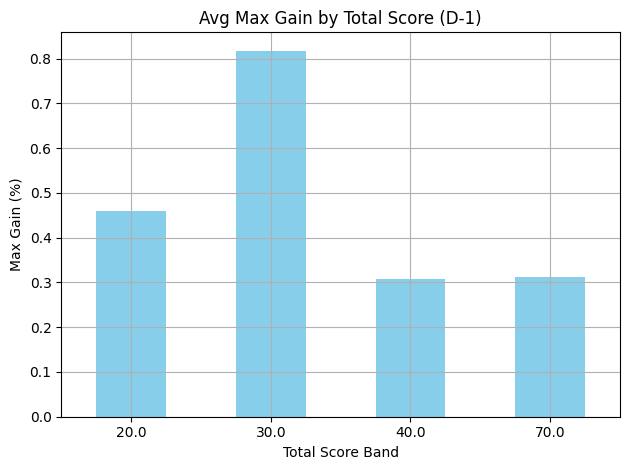

In [ ]:
# ✅ Breakout Signal Backtest Notebook (Clean Start)

# ─────────────────────────────────────
# Step 1: Load Full Breakout Data with Scores
import pandas as pd

path = "/content/m18-model2/data/processed/breakouts_with_total_score.csv"
df_all = pd.read_csv(path)
df_all["breakout_date"] = pd.to_datetime(df_all["breakout_date"])

# ─────────────────────────────────────
# Step 2: Load the Aligned Bar Data (D-3 to PK-1)
df_bars = pd.read_csv("/content/breakout_bars_aligned.csv")
df_bars["date"] = pd.to_datetime(df_bars["date"])

# ─────────────────────────────────────
# Step 3: Merge Scores into Aligned Bars (on breakout_date)
df_bars["breakout_date"] = df_bars.groupby("symbol")["date"].transform("max")  # fallback if not present

df_all_keys = df_all[["symbol", "breakout_date", "market_level", "trend_score", "mom_score", "vty_score", "vol_score", "total_score", "max_gain"]]

# ensure types align
df_bars["symbol"] = df_bars["symbol"].astype(str)
df_bars["breakout_date"] = pd.to_datetime(df_bars["breakout_date"])
df_all_keys["symbol"] = df_all_keys["symbol"].astype(str)
df_all_keys["breakout_date"] = pd.to_datetime(df_all_keys["breakout_date"])

# merge
merged = df_bars.merge(
    df_all_keys,
    on=["symbol", "breakout_date"],
    how="left"
)

# ─────────────────────────────────────
# Step 4: Filter D-1 Rows

df_d1 = merged[merged["label"] == "D-1"].copy()
df_d1 = df_d1.dropna(subset=["total_score", "max_gain"])
df_d1["score_band"] = (df_d1["total_score"] // 10) * 10

# ─────────────────────────────────────
# Step 5: Group + Plot
import matplotlib.pyplot as plt

band_perf = df_d1.groupby("score_band")["max_gain"].agg(["count", "mean", "median", "min", "max"])
display(band_perf)

band_perf["mean"].plot(
    kind="bar",
    title="Avg Max Gain by Total Score (D-1)",
    ylabel="Max Gain (%)",
    xlabel="Total Score Band",
    color="skyblue"
)
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


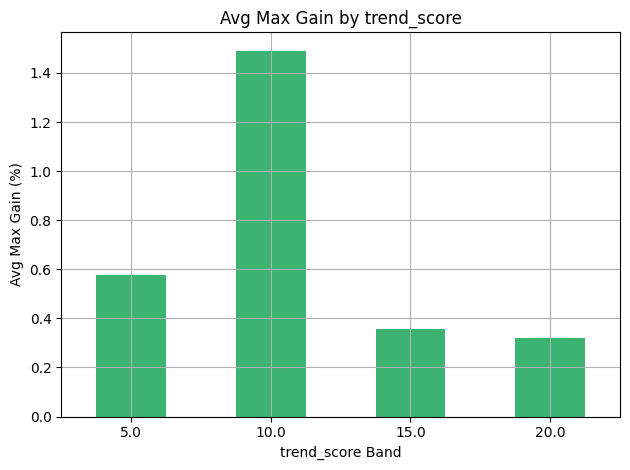

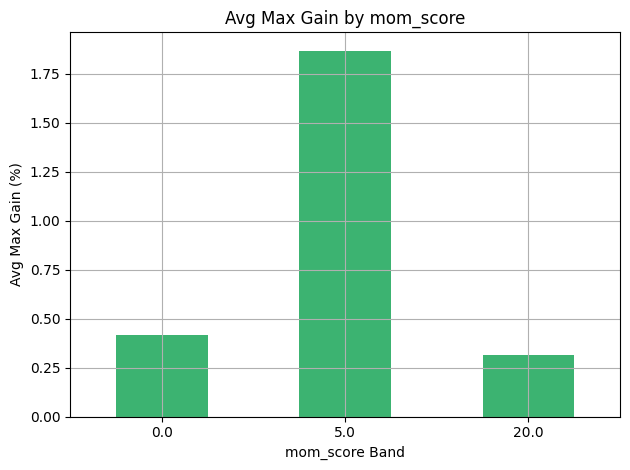

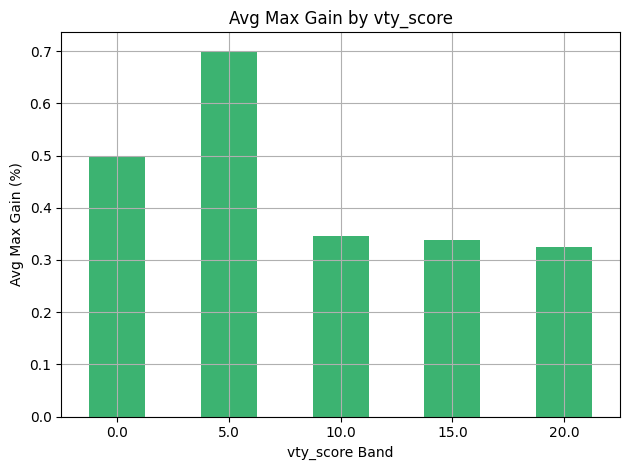

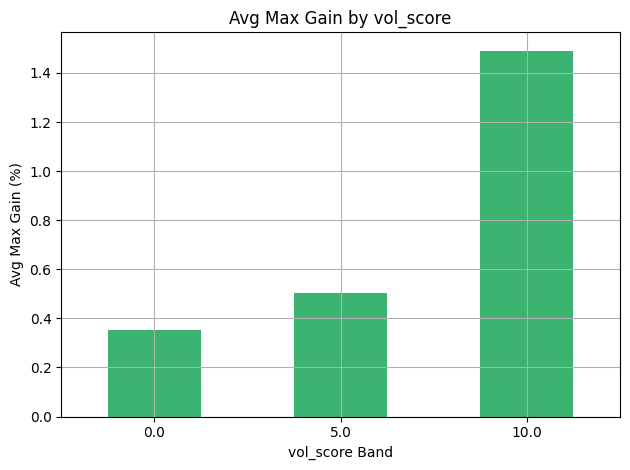

In [ ]:
import matplotlib.pyplot as plt

# Sub-scores to test
sub_scores = ["trend_score", "mom_score", "vty_score", "vol_score"]

for score in sub_scores:
    df_d1[f"{score}_band"] = (df_d1[score] // 5) * 5  # Bin by 5-point range

    band_stats = df_d1.groupby(f"{score}_band")["max_gain"].agg(["count", "mean"])

    # Skip if band is empty
    if band_stats.empty:
        continue

    # Plot
    band_stats["mean"].plot(kind="bar", title=f"Avg Max Gain by {score}", color="mediumseagreen")
    plt.xlabel(f"{score} Band")
    plt.ylabel("Avg Max Gain (%)")
    plt.grid(True)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [ ]:
# Show sample of available indicators
df_merged.columns.tolist()


['symbol',
 'label',
 'date',
 'Date',
 'Close',
 'High',
 'Low',
 'Open',
 'Volume',
 'breakout_date',
 'market_level',
 'trend_score',
 'mom_score',
 'vty_score',
 'vol_score',
 'total_score']

In [ ]:
import os
pd.read_csv("/content/crypto_data/SOL-USD.csv", nrows=3).columns.tolist()


['Price', 'Close', 'High', 'Low', 'Open', 'Volume']

In [ ]:
df_merged = pd.read_csv("/content/breakout_bars_aligned.csv")
df_merged.columns = df_merged.columns.str.strip().str.lower()  # normalize
df_merged["date"] = pd.to_datetime(df_merged["date"])


ValueError: cannot assemble with duplicate keys

In [ ]:
cols = df_merged.columns
duplicates = cols[cols.duplicated()]
print("Duplicate columns:", duplicates.tolist())


Duplicate columns: ['date']


In [ ]:
if "Date" in df_merged.columns:
    df_merged = df_merged.drop(columns="Date")


In [ ]:
import pandas as pd

# Corrected full path
df_all = pd.read_csv("/content/m18-model2/data/processed/breakouts_with_total_score.csv")
df_all["breakout_date"] = pd.to_datetime(df_all["breakout_date"])

df_all.head(2)


,symbol,breakout_date,start_price_x,max_window_price_x,max_gain_x,market_level,Date_x,Close_x,High_x,Low_x,...,Volume,close,volume,high,low,obv,cmf,rvol,vol_score,total_score
0,1INCH-USD,2021-10-24,3.810249,5.674350,0.489233,7,2021-10-24,3.810249,4.066686,3.691691,...,440583618,3.810249,440583618,4.066686,3.691691,11313261492,0.071924,1.072567,4.125,73.225
1,A-USD,2020-07-24,0.005973,0.011742,0.965846,7,2020-07-24,0.005973,0.010883,0.003727,...,1878,0.005973,1878,0.010883,0.003727,20931,-0.088452,2.938737,6.750,20.450


In [ ]:
import pandas as pd

# Corrected full path
df_all = pd.read_csv("/content/m18-model2/data/processed/breakouts_with_total_score.csv")
df_all["breakout_date"] = pd.to_datetime(df_all["breakout_date"])

df_all.head(2)


,symbol,breakout_date,start_price_x,max_window_price_x,max_gain_x,market_level,Date_x,Close_x,High_x,Low_x,...,Volume,close,volume,high,low,obv,cmf,rvol,vol_score,total_score
0,1INCH-USD,2021-10-24,3.810249,5.674350,0.489233,7,2021-10-24,3.810249,4.066686,3.691691,...,440583618,3.810249,440583618,4.066686,3.691691,11313261492,0.071924,1.072567,4.125,73.225
1,A-USD,2020-07-24,0.005973,0.011742,0.965846,7,2020-07-24,0.005973,0.010883,0.003727,...,1878,0.005973,1878,0.010883,0.003727,20931,-0.088452,2.938737,6.750,20.450


In [ ]:
# Save the df_aligned from your previous breakout bar extraction step
df_aligned.to_csv("/content/breakout_bars_with_indicators.csv", index=False)
print("✅ breakout_bars_with_indicators.csv saved:", df_aligned.shape)


✅ breakout_bars_with_indicators.csv saved: (33829, 9)


In [ ]:
import os
import pandas as pd

# Confirm df_all already loaded with breakout symbols and dates
data_path = "/content/crypto_data"
rows = []

for symbol in df_all["symbol"].unique():
    csv_path = os.path.join(data_path, f"{symbol}.csv")
    if not os.path.exists(csv_path):
        continue

    price_df = pd.read_csv(csv_path, skiprows=2)
    price_df.columns = [str(c).strip().lower() for c in price_df.columns]
    price_df["date"] = pd.to_datetime(price_df["date"])
    price_df = price_df.set_index("date")

    for _, row in df_all[df_all["symbol"] == symbol].iterrows():
        b_date = pd.to_datetime(row["breakout_date"])
        try:
            idx = price_df.index.get_loc(b_date)
        except KeyError:
            continue

        start = idx - 3
        end = idx + 4
        if start < 0 or end > len(price_df):
            continue

        # ✅ Preserve ALL columns (including indicators)
        window = price_df.iloc[start:end]
        labels = ["D-3", "D-2", "D-1", "D0", "PK-1", "PK-2", "PK-3"]
        window = window.copy()
        window["label"] = labels
        window["symbol"] = symbol
        window["breakout_date"] = b_date
        rows.append(window.reset_index())

# Combine and save
df_aligned = pd.concat(rows, ignore_index=True)
df_aligned.to_csv("/content/breakout_bars_with_indicators.csv", index=False)
print("✅ breakout_bars_with_indicators.csv saved:", df_aligned.shape)


✅ breakout_bars_with_indicators.csv saved: (33845, 9)


In [ ]:
!pip install ta --quiet


  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd

df = pd.read_csv("/content/m18-model2/data/processed/breakouts_with_total_score.csv")
df.columns = [c.strip().lower() for c in df.columns]
df = df.dropna()

print("✅ Loaded:", df.shape)
df.head(2)


✅ Loaded: (4754, 61)


,symbol,breakout_date,start_price_x,max_window_price_x,max_gain_x,market_level,date_x,close_x,high_x,low_x,...,volume,close,volume,high,low,obv,cmf,rvol,vol_score,total_score
81,A-USD,2024-06-24,0.002195,0.004787,1.180866,3,2024-06-24,0.002195,0.002269,0.002139,...,0,0.002195,0,0.002269,0.002139,64584,0.255396,0.000000,8.25,15.650
82,A-USD,2024-06-28,0.004689,0.006666,0.421625,3,2024-06-28,0.004689,0.004838,0.004676,...,1,0.004689,1,0.004838,0.004676,64652,0.231370,0.005435,8.25,15.025


<ipython-input-56-1290514965>:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


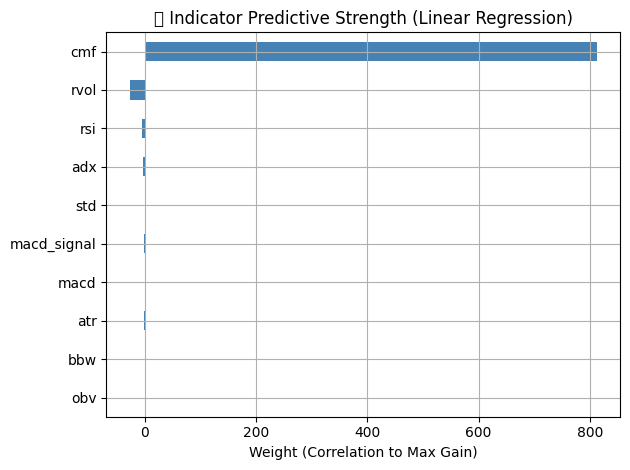

In [ ]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Select only sub-indicator columns
indicators = ["rsi", "macd", "macd_signal", "adx", "obv", "cmf", "rvol", "atr", "std", "bbw"]
df_sub = df[indicators + ["max_gain_x"]].dropna()

# Fit regression
X = df_sub[indicators]
y = df_sub["max_gain_x"]
model = LinearRegression().fit(X, y)

# Get and sort feature importances
weights = pd.Series(model.coef_, index=indicators).sort_values(key=abs, ascending=False)

# Plot
weights.plot(kind="barh", color="steelblue")
plt.title("📊 Indicator Predictive Strength (Linear Regression)")
plt.xlabel("Weight (Correlation to Max Gain)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-57-2796938134>:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


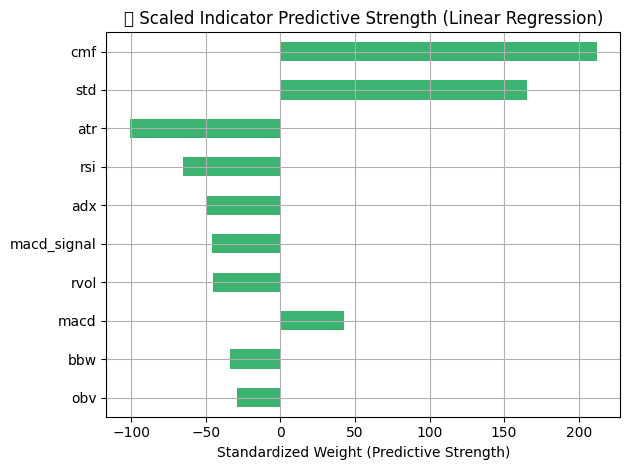

In [57]:
from sklearn.preprocessing import StandardScaler

# Prepare data
indicators = ["rsi", "macd", "macd_signal", "adx", "obv", "cmf", "rvol", "atr", "std", "bbw"]
df_sub = df[indicators + ["max_gain_x"]].dropna()

X = df_sub[indicators]
y = df_sub["max_gain_x"]

# Scale features to mean=0, std=1
X_scaled = StandardScaler().fit_transform(X)

# Refit regression
model = LinearRegression().fit(X_scaled, y)
weights = pd.Series(model.coef_, index=indicators).sort_values(key=abs, ascending=False)

# Plot
weights.plot(kind="barh", color="mediumseagreen")
plt.title("📊 Scaled Indicator Predictive Strength (Linear Regression)")
plt.xlabel("Standardized Weight (Predictive Strength)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
# Normalize column names first
df_all.columns = df_all.columns.str.strip().str.lower()

# Check what's there now
print(df_all.columns.tolist())


['symbol', 'breakout_date', 'start_price_x', 'max_window_price_x', 'max_gain_x', 'market_level', 'date_x', 'close_x', 'high_x', 'low_x', 'open_x', 'volume_x', 'close_x', 'high_x', 'low_x', 'ema_5', 'ema_50', 'ema_200', 'rsi', 'macd', 'macd_signal', 'adx', 'ema_10', 'ema_100', 'trend_score', 'mom_score', 'start_price_y', 'max_window_price_y', 'max_gain_y', 'date_y', 'close_y', 'high_y', 'low_y', 'open_y', 'volume_y', 'close_y', 'high_y', 'low_y', 'atr', 'std', 'bbw', 'rng', 'vty_score', 'start_price', 'max_window_price', 'max_gain', 'date', 'close', 'high', 'low', 'open', 'volume', 'close', 'volume', 'high', 'low', 'obv', 'cmf', 'rvol', 'vol_score', 'total_score']


In [3]:
import pandas as pd

# Load your enriched breakout dataset
df_all = pd.read_csv("/content/m18-model2/data/processed/breakouts_with_total_score.csv")

# Ensure datetime format
df_all["breakout_date"] = pd.to_datetime(df_all["breakout_date"])

# Preview it
df_all.head(2)


,symbol,breakout_date,start_price_x,max_window_price_x,max_gain_x,market_level,Date_x,Close_x,High_x,Low_x,...,Volume,close,volume,high,low,obv,cmf,rvol,vol_score,total_score
0,1INCH-USD,2021-10-24,3.810249,5.674350,0.489233,7,2021-10-24,3.810249,4.066686,3.691691,...,440583618,3.810249,440583618,4.066686,3.691691,11313261492,0.071924,1.072567,4.125,73.225
1,A-USD,2020-07-24,0.005973,0.011742,0.965846,7,2020-07-24,0.005973,0.010883,0.003727,...,1878,0.005973,1878,0.010883,0.003727,20931,-0.088452,2.938737,6.750,20.450


In [4]:
# Select only the relevant sub-indicators and target
df_subset = df_all[["cmf", "std", "atr", "max_gain_x"]].dropna()

# Reduce for clarity and performance
df_subset = df_subset.sample(n=500, random_state=42)


In [5]:
# Select only the top 3 indicators (cmf, std, atr) and target (max_gain_x)
df_subset = df_all[["cmf", "std", "atr", "max_gain_x"]].dropna()

# Sample 500 rows to keep the plot readable
df_subset = df_subset.sample(n=500, random_state=42)

# Check structure
df_subset.head()


,cmf,std,atr,max_gain_x
3317,0.067203,0.030707,5.489251e-02,0.388186
2533,0.066407,10.236955,3.736011e+00,0.367893
1041,-0.164013,0.084946,7.542217e-02,0.349935
3307,0.113784,0.051000,5.525983e-02,0.523774
4401,0.000000,0.000000,1.094634e-08,0.333333


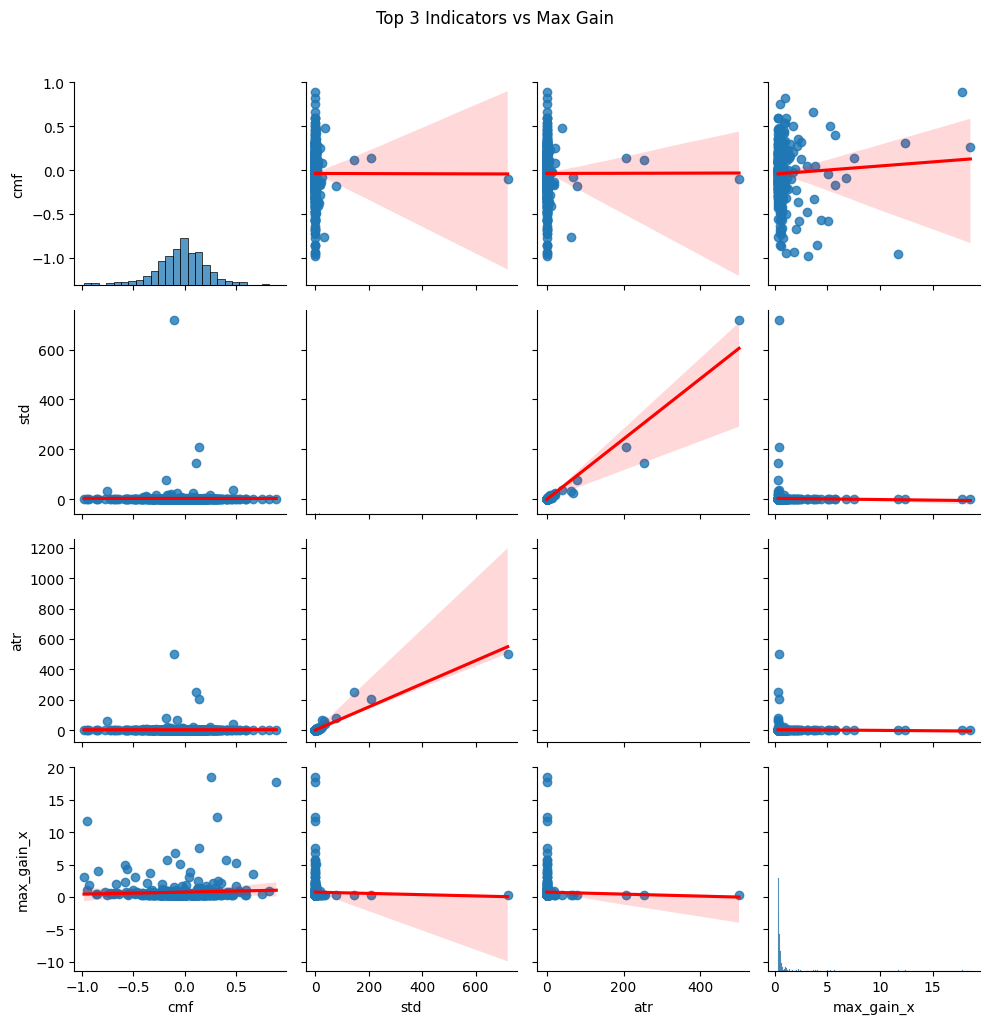

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create pairplot to visually inspect linear relationships
sns.pairplot(df_subset, kind="reg", plot_kws={"line_kws": {"color": "red"}})
plt.suptitle("Top 3 Indicators vs Max Gain", y=1.02)
plt.tight_layout()
plt.show()


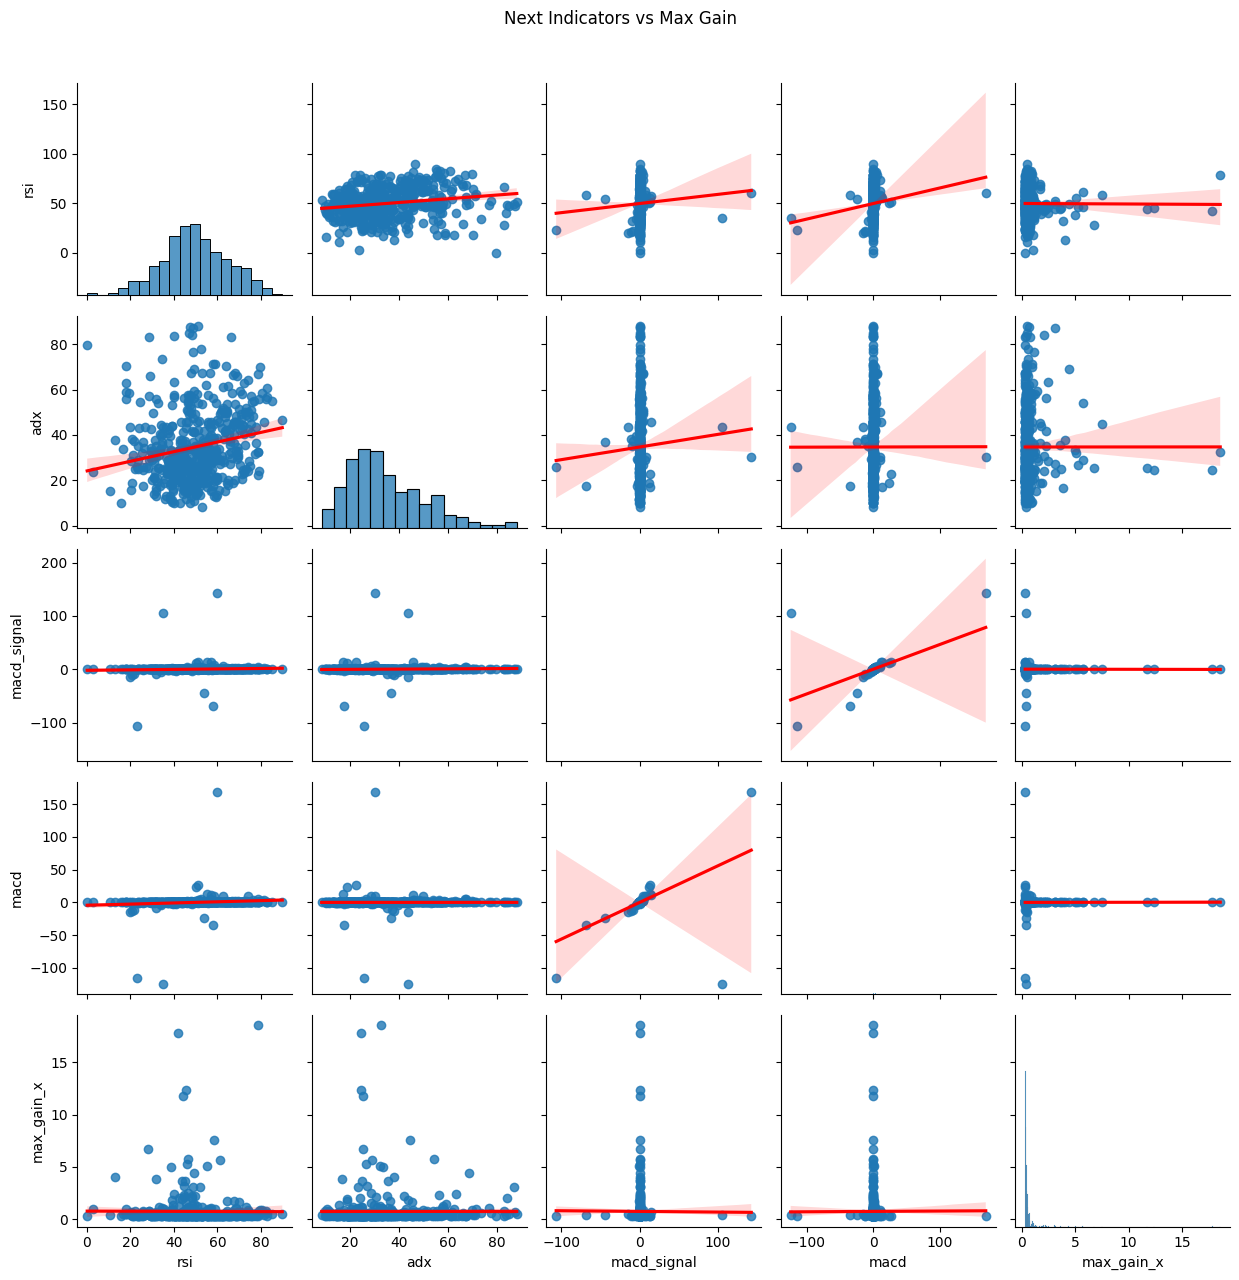

In [7]:
# Select additional indicators
df_subset = df_all[["rsi", "adx", "macd_signal", "macd", "max_gain_x"]].dropna()

# Sample to reduce plot load
df_subset = df_subset.sample(n=500, random_state=42)

# Plot pairplot to evaluate relationships
sns.pairplot(df_subset, kind="reg", plot_kws={"line_kws": {"color": "red"}})
plt.suptitle("Next Indicators vs Max Gain", y=1.02)
plt.tight_layout()
plt.show()


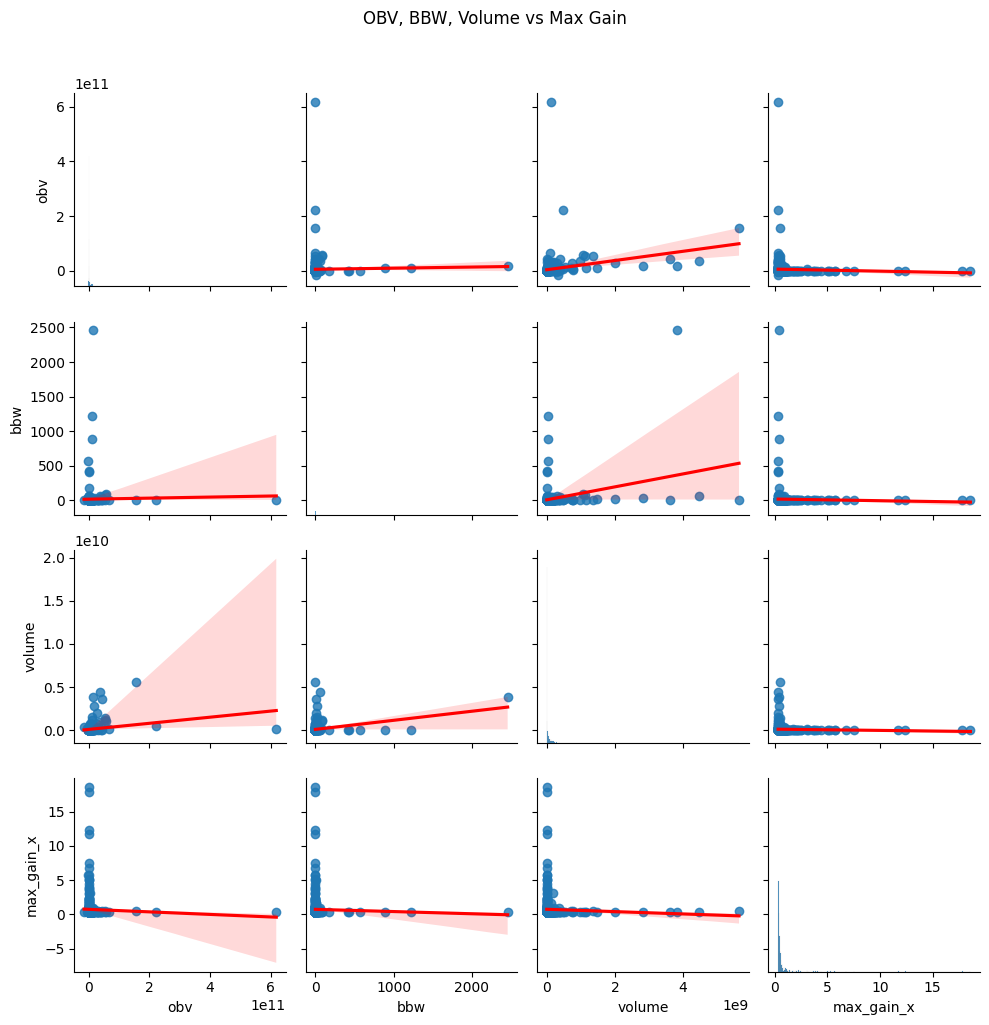

In [8]:
# Select the final set of sub-indicators
df_subset = df_all[["obv", "bbw", "volume", "max_gain_x"]].dropna()

# Sample 500 rows for performance
df_subset = df_subset.sample(n=500, random_state=42)

# Plot pairwise relationships
sns.pairplot(df_subset, kind="reg", plot_kws={"line_kws": {"color": "red"}})
plt.suptitle("OBV, BBW, Volume vs Max Gain", y=1.02)
plt.tight_layout()
plt.show()
